## Example of collecting data from CARLA

In [129]:
import carla
import numpy as np
import matplotlib.pyplot as plt
client = carla.Client('localhost', 2000)
client.set_timeout(2.0)
world = client.get_world()
map = world.get_map()
spawn_points = map.get_spawn_points()
settings = world.get_settings()
ego_vehicle = None
imu_sensor = None
gnss_sensor = None
t = []
gt_p = []
gt_v = []
gt_r = []
gnss_data = []
imu_f_data = []
imu_w_data = []
imu_t = []
gnss_t = []
try:
    settings.synchronous_mode = True
    settings.fixed_delta_seconds = 0.005
    world.apply_settings(settings)
    spectator = world.get_spectator()
    spectator.set_transform(carla.Transform(spawn_points[0].location + carla.Location(z=50), carla.Rotation(pitch=-90)))
    tesla_model_3 = world.get_blueprint_library().filter('model3')[0]
    ego_vehicle = world.spawn_actor(tesla_model_3, spawn_points[0])
    
    gnss_sensor = world.get_blueprint_library().find('sensor.other.gnss')
    gnss_sensor.set_attribute('sensor_tick', '0.001')
    gnss_sensor_transform = carla.Transform(carla.Location(x=1.0, z=2.8))
    gnss_sensor = world.spawn_actor(gnss_sensor, gnss_sensor_transform, attach_to=ego_vehicle)
    def gnss_callback(data):

        # lat_rad = (np.deg2rad(data.latitude) + np.pi) % (2 * np.pi) - np.pi
        # lon_rad = (np.deg2rad(data.longitude) + np.pi) % (2 * np.pi) - np.pi
        # R = 6378135 # Aequatorradii
        # x = R * np.sin(lon_rad) * np.cos(lat_rad)       # iO
        # y = R * np.sin(-lat_rad)                               # iO
        # z = data.altitude
        # gnss_data.append([x, y, z])
        gnss_data.append([data.transform.location.x, data.transform.location.y, data.transform.location.z])
        gnss_t.append(data.timestamp)
    gnss_sensor.listen(lambda data: gnss_callback(data))
    
    imu_sensor = world.get_blueprint_library().find('sensor.other.imu')
    imu_sensor.set_attribute('sensor_tick', '0.001')
    imu_sensor_transform = carla.Transform(carla.Location(x=1.0, z=1.8))
    imu_sensor = world.spawn_actor(imu_sensor, imu_sensor_transform, attach_to=ego_vehicle)
    def imu_callback(data):
        imu_f_data.append([data.accelerometer.x, data.accelerometer.y, data.accelerometer.z])
        imu_w_data.append([data.gyroscope.x, data.gyroscope.y, data.gyroscope.z])
        imu_t.append(data.timestamp)
    imu_sensor.listen(lambda data: imu_callback(data))
    ego_vehicle.set_autopilot(True)
    world.tick()

    t.clear()
    gt_p.clear()
    gt_r.clear()
    gt_v.clear()
    gnss_data.clear()
    imu_f_data.clear()
    imu_w_data.clear()
    imu_t.clear()
    gnss_t.clear()

    DURATION = 2
    total_time_steps = DURATION / settings.fixed_delta_seconds
    for i in range(int(total_time_steps)):
        t.append(i * settings.fixed_delta_seconds)
        loc = ego_vehicle.get_location()
        veh = ego_vehicle.get_velocity()
        ori = ego_vehicle.get_transform()
        gt_p.append([loc.x, loc.y, loc.z])
        gt_v.append([veh.x, veh.y, veh.z])
        gt_r.append([ori.rotation.pitch, ori.rotation.yaw, ori.rotation.roll])
        world.tick()
except Exception as e:
    print(e)
finally:
    settings.synchronous_mode = False
    world.apply_settings(settings)
    if ego_vehicle is not None:
        ego_vehicle.destroy()
    if gnss_sensor is not None:
        gnss_sensor.destroy()
    if imu_sensor is not None:
        imu_sensor.destroy()

In [144]:
from data import Data
from utils import StampedData
created_gt_data = Data(t=np.array(t), p=np.array(gt_p), v=np.array(gt_v), r=np.array(gt_r))

imu_f_data_stamped = StampedData()
imu_f_data_stamped.t = np.array(imu_t)
imu_f_data_stamped.data = np.array(imu_f_data)

imu_w_data_stamped = StampedData()
imu_w_data_stamped.t = np.array(imu_t)
imu_w_data_stamped.data = np.array(imu_w_data)

gnss_data_stamped = StampedData()
gnss_data_stamped.t = np.array(gnss_t)
gnss_data_stamped.data = np.array(gnss_data)

In [131]:

print(imu_f_data_stamped.data.shape)
print(imu_f_data_stamped.t.shape)
print(imu_w_data_stamped.t.shape)
print(imu_w_data_stamped.data.shape)

(404, 3)
(404,)
(404,)
(404, 3)


In [150]:
print(gnss_data_stamped.data)
print(gnss_data_stamped.t)

[[-63.64484787  24.47378922   3.39926481]
 [-63.64484787  24.47378922   3.39853001]
 [-63.64484787  24.47378922   3.39754987]
 ...
 [-55.55677032  22.2075119    2.80206513]
 [-55.52108383  22.18894768   2.80205631]
 [-55.4854393   22.17035294   2.80204868]]
[780.34776523 780.35276523 780.35776523 780.36276523 780.36776523
 780.37276523 780.37776523 780.38276523 780.38776523 780.39276523
 780.39776523 780.40276523 780.40776523 780.41276523 780.41776523
 780.42276523 780.42776523 780.43276523 780.43776523 780.44276523
 780.44776523 780.45276523 780.45776523 780.46276523 780.46776523
 780.47276523 780.47776523 780.48276523 780.48776523 780.49276523
 780.49776523 780.50276523 780.50776523 780.51276523 780.51776523
 780.52276523 780.52776523 780.53276523 780.53776523 780.54276523
 780.54776523 780.55276523 780.55776523 780.56276523 780.56776523
 780.57276523 780.57776523 780.58276523 780.58776523 780.59276523
 780.59776523 780.60276523 780.60776523 780.61276523 780.61776523
 780.62276523 78

In [151]:
print(created_gt_data.p)

[[-6.46448441e+01  2.44710102e+01  5.99754989e-01]
 [-6.46448441e+01  2.44710102e+01  5.99264920e-01]
 [-6.46448441e+01  2.44710102e+01  5.98529935e-01]
 ...
 [-5.65988426e+01  2.26179295e+01  2.01313011e-03]
 [-5.65622215e+01  2.26015701e+01  2.01828009e-03]
 [-5.65256615e+01  2.25851555e+01  2.02323915e-03]]


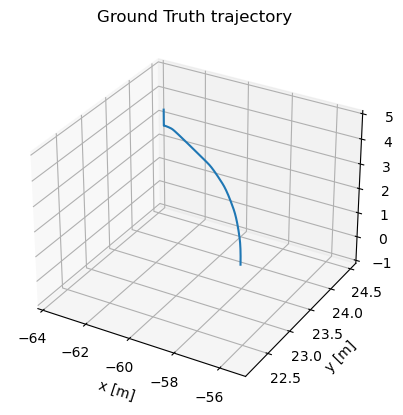

In [134]:
import matplotlib.pyplot as plt
import numpy as np
gt_fig = plt.figure()
ax = gt_fig.add_subplot(111, projection='3d')
ax.plot(gnss_data_stamped.data[:,0], gnss_data_stamped.data[:,1], gnss_data_stamped.data[:,2])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Ground Truth trajectory')
ax.set_zlim(-1, 5)
plt.show()

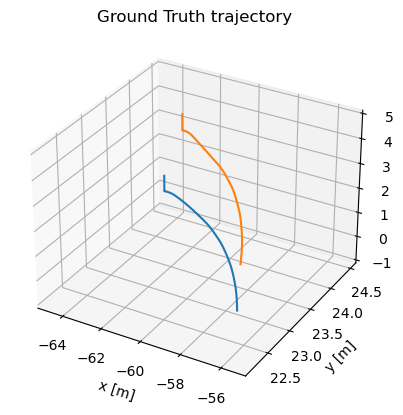

In [148]:
import matplotlib.pyplot as plt
import numpy as np
gt_fig = plt.figure()
ax = gt_fig.add_subplot(111, projection='3d')
ax.plot(created_gt_data.p[:,0], created_gt_data.p[:,1], created_gt_data.p[:,2],label='Ground')
ax.plot(gnss_data_stamped.data[:,0], gnss_data_stamped.data[:,1], gnss_data_stamped.data[:,2],label='gnss')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Ground Truth trajectory')
ax.set_zlim(-1, 5)
plt.show()

In [155]:
from rotations import Quaternion,rpy_jacobian_axis_angle
var_imu_f = 0.10
var_imu_w = 0.10
var_gnss  = 0.10
var_lidar = 2.00
g = np.array([0, 0, -9.81])  # gravity
l_jac = np.zeros([9, 6])
l_jac[3:, :] = np.eye(6)  # motion model noise jacobian
h_jac = np.zeros([3, 9])
h_jac[:, :3] = np.eye(3)  # measurement model jacobian
p_est = np.zeros([imu_f_data_stamped.data.shape[0], 3])  # position estimates
v_est = np.zeros([imu_f_data_stamped.data.shape[0], 3])  # velocity estimates
q_est = np.zeros([imu_f_data_stamped.data.shape[0], 4])  # orientation estimates as quaternions
p_cov = np.zeros([imu_f_data_stamped.data.shape[0], 9, 9])  # covariance matrices at each timestep
p_est[0] = created_gt_data.p[0]
v_est[0] = created_gt_data.v[0]
q_est[0] = Quaternion(euler=created_gt_data.r[0]).to_numpy()
p_cov[0] = np.zeros(9)  # covariance of estimate
gnss_i  = 0
lidar_i = 0
gnss_t = list(gnss_data_stamped.t)


c:\Users\sean\Downloads\Vehicle-State-Estimation-main\Vehicle-State-Estimation-main\data\rotations.py:118: RuntimeWarning: invalid value encountered in arcsin
  pitch = np.arcsin(2 * (self.w * self.y - self.z * self.x))
c:\Users\sean\Downloads\Vehicle-State-Estimation-main\Vehicle-State-Estimation-main\data\rotations.py:107: RuntimeWarning: invalid value encountered in arccos
  t = 2*np.arccos(self.w)


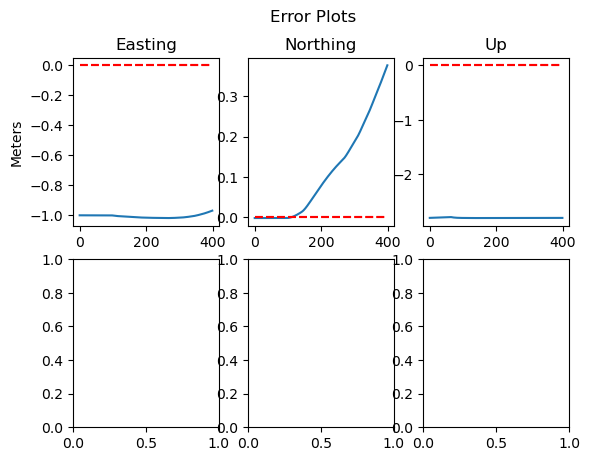

In [156]:
from rotations import Quaternion,rpy_jacobian_axis_angle
error_fig, ax = plt.subplots(2, 3)
error_fig.suptitle('Error Plots')
num_gt = created_gt_data.p.shape[0]
p_est_euler = []
p_cov_euler_std = []

# Convert estimated quaternions to euler angles
for i in range(len(gnss_data_stamped.data)):
    qc = Quaternion(*gnss_data_stamped.data[i, :])
    p_est_euler.append(qc.to_euler())

    # First-order approximation of RPY covariance
    J = rpy_jacobian_axis_angle(qc.to_axis_angle())
    p_cov_euler_std.append(np.sqrt(np.diagonal(J @ p_cov[i, 6:, 6:] @ J.T)))

p_est_euler = np.array(p_est_euler)
p_cov_euler_std = np.array(p_cov_euler_std)

# Get uncertainty estimates from P matrix
p_cov_std = np.sqrt(np.diagonal(p_cov[:, :6, :6], axis1=1, axis2=2))

titles = ['Easting', 'Northing', 'Up', 'Roll', 'Pitch', 'Yaw']
for i in range(3):
    ax[0, i].plot(range(num_gt), created_gt_data.p[:, i] - gnss_data_stamped.data[:num_gt, i])
    ax[0, i].plot(range(num_gt),  3 * p_cov_std[:num_gt, i], 'r--')
    ax[0, i].plot(range(num_gt), -3 * p_cov_std[:num_gt, i], 'r--')
    ax[0, i].set_title(titles[i])
ax[0,0].set_ylabel('Meters')


plt.show()


In [158]:
import rotations
from es_ekf import measurement_update
for k in range(1, imu_f_data_stamped.data.shape[0]):  # start at 1 b/c we have initial prediction from gt
    delta_t = imu_f_data_stamped.t[k] - imu_f_data_stamped.t[k-1]

    # 1. Update state with IMU inputs
    q_prev = rotations.Quaternion(*q_est[k - 1, :]) # previous orientation as a quaternion object
    q_curr = rotations.Quaternion(axis_angle=(imu_w_data_stamped.data[k - 1]*delta_t)) # current IMU orientation
    c_ns = q_prev.to_mat() # previous orientation as a matrix
    f_ns = (c_ns @ imu_f_data_stamped.data[k - 1]) + g # calculate sum of forces
    p_check = p_est[k - 1, :] + delta_t*v_est[k - 1, :] + 0.5*(delta_t**2)*f_ns
    v_check = v_est[k - 1, :] + delta_t*f_ns
    q_check = q_prev.quat_mult_left(q_curr)

    # 1.1 Linearize the motion model and compute Jacobians
    f_jac = np.eye(9) # motion model jacobian with respect to last state
    f_jac[0:3, 3:6] = np.eye(3)*delta_t
    f_jac[3:6, 6:9] = -rotations.skew_symmetric(c_ns @ imu_f_data_stamped.data[k - 1])*delta_t

    # 2. Propagate uncertainty
    q_cov = np.zeros((6, 6)) # IMU noise covariance
    q_cov[0:3, 0:3] = delta_t**2 * np.eye(3)*var_imu_f
    q_cov[3:6, 3:6] = delta_t**2 * np.eye(3)*var_imu_w
    p_cov_check = f_jac @ p_cov[k - 1, :, :] @ f_jac.T + l_jac @ q_cov @ l_jac.T

    # 3. Check availability of GNSS and LIDAR measurements
    if imu_f_data_stamped.t[k] in gnss_t:
        gnss_i = gnss_t.index(imu_f_data_stamped.t[k])
        p_check, v_check, q_check, p_cov_check = \
            measurement_update(var_gnss, p_cov_check, gnss_data_stamped.data[gnss_i], p_check, v_check, q_check)

    # Update states (save)
    p_est[k, :] = p_check
    v_est[k, :] = v_check
    q_est[k, :] = q_check
    p_cov[k, :, :] = p_cov_check


In [166]:
print(p_est)
print(created_gt_data.p)

[[-6.46448441e+01  2.44710102e+01  5.99754989e-01]
 [-6.46448246e+01  2.44710102e+01  5.99508439e-01]
 [-3.34486899e+01  1.21457436e+01 -5.62497087e+00]
 ...
 [ 4.67863554e+03 -1.92438082e+03 -1.29669707e+03]
 [ 4.63758163e+03 -1.90787319e+03 -1.28823982e+03]
 [ 4.63325949e+03 -1.90645510e+03 -1.28977807e+03]]
[[-6.46448441e+01  2.44710102e+01  5.99754989e-01]
 [-6.46448441e+01  2.44710102e+01  5.99264920e-01]
 [-6.46448441e+01  2.44710102e+01  5.98529935e-01]
 ...
 [-5.65988426e+01  2.26179295e+01  2.01313011e-03]
 [-5.65622215e+01  2.26015701e+01  2.01828009e-03]
 [-5.65256615e+01  2.25851555e+01  2.02323915e-03]]


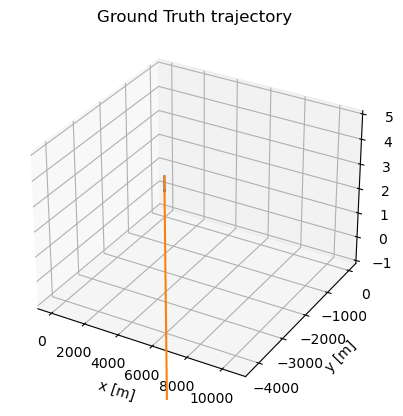

In [167]:
import matplotlib.pyplot as plt
import numpy as np
gt_fig = plt.figure()
ax = gt_fig.add_subplot(111, projection='3d')
ax.plot(created_gt_data.p[:,0], created_gt_data.p[:,1], created_gt_data.p[:,2],label='Ground')
ax.plot(p_est[:,0], p_est[:,1], p_est[:,2],label='gnss')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Ground Truth trajectory')
ax.set_zlim(-1, 5)
plt.show()


c:\Users\sean\Downloads\Vehicle-State-Estimation-main\Vehicle-State-Estimation-main\data\rotations.py:33: RuntimeWarning: invalid value encountered in sqrt
  [0, t/np.sqrt(1 - t**2*u[1]**2), 0, u[1]/np.sqrt(1 - t**2*u[1]**2)],


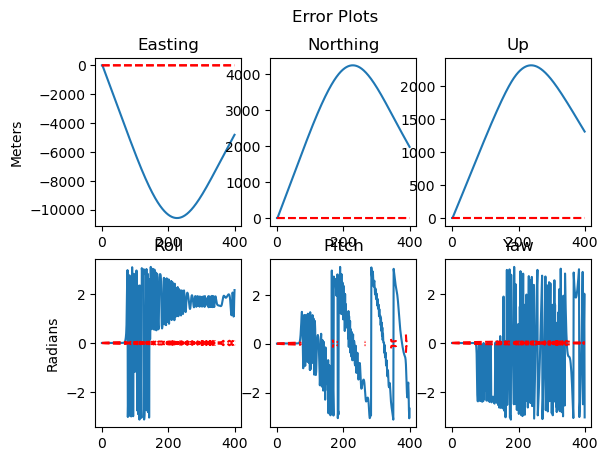

In [168]:
error_fig, ax = plt.subplots(2, 3)
error_fig.suptitle('Error Plots')
num_gt = created_gt_data.p.shape[0]
p_est_euler = []
p_cov_euler_std = []

from rotations import angle_normalize, rpy_jacobian_axis_angle, skew_symmetric, Quaternion
# Convert estimated quaternions to euler angles
for i in range(len(q_est)):
    qc = Quaternion(*q_est[i, :])
    p_est_euler.append(qc.to_euler())

    # First-order approximation of RPY covariance
    J = rpy_jacobian_axis_angle(qc.to_axis_angle())
    p_cov_euler_std.append(np.sqrt(np.diagonal(J @ p_cov[i, 6:, 6:] @ J.T)))

p_est_euler = np.array(p_est_euler)
p_cov_euler_std = np.array(p_cov_euler_std)

# Get uncertainty estimates from P matrix
p_cov_std = np.sqrt(np.diagonal(p_cov[:, :6, :6], axis1=1, axis2=2))

titles = ['Easting', 'Northing', 'Up', 'Roll', 'Pitch', 'Yaw']
for i in range(3):
    ax[0, i].plot(range(num_gt), created_gt_data.p[:, i] - p_est[:num_gt, i])
    ax[0, i].plot(range(num_gt),  3 * p_cov_std[:num_gt, i], 'r--')
    ax[0, i].plot(range(num_gt), -3 * p_cov_std[:num_gt, i], 'r--')
    ax[0, i].set_title(titles[i])
ax[0,0].set_ylabel('Meters')

for i in range(3):
    ax[1, i].plot(range(num_gt), \
        angle_normalize(created_gt_data.r[:, i] - p_est_euler[:num_gt, i]))
    ax[1, i].plot(range(num_gt),  3 * p_cov_euler_std[:num_gt, i], 'r--')
    ax[1, i].plot(range(num_gt), -3 * p_cov_euler_std[:num_gt, i], 'r--')
    ax[1, i].set_title(titles[i+3])
ax[1,0].set_ylabel('Radians')
plt.show()
